<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U-net_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install tacoreader rasterio

Text(0.5, 1.0, 'Human label')

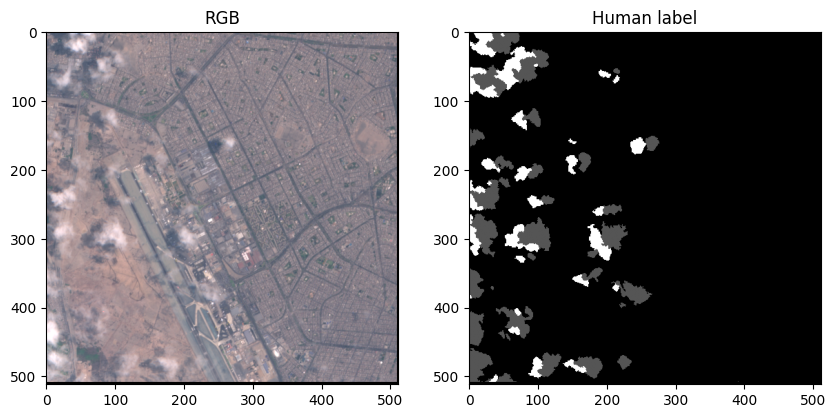

In [20]:
# @Setup and accessing CloudSEN12+
# REWRITE WHOLE SECTION - COPIED

import tacoreader
import rasterio as rio
import matplotlib.pyplot
import numpy
import torch

# initalise and set up the logger

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [21]:
type(s2_l1c_data)

tensor_datapoint_rgb = torch.from_numpy(datapoint_rgb);
tensor_datapoint_rgb = tensor_datapoint_rgb.to(torch.float32)

#todo -
"""
a. work out how to transfer images and visualise progress
b. determine required images and what I should use
c. being to save progress
d. make the model tech agnostic
e. Get a logger setup - requires a working file directory
  import logging
  self.logger = logging.getLogger(__name__)
1. get rough model working
2. build the Unet model
"""

#useful knowledge
"""
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
"""

'\n1. keyboard shortcut to comment and uncomment out things is ctrl + "/"\n2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512\n3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information\n'

In [22]:
import torch
import torch.nn as nn

device = "cpu"


# encoder layer - going "down the U"; i.e decreasing the resolution at the for more colour channels
class encoder_layer(nn.Module):
#
  def __init__ (self, channels_in): #channels_in
    # Parameters and key functions go here!
    super().__init__()

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,      # the amount of colours channels
        out_channels = channels_in, #* 2,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        #bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )

    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = channels_in, #* 2,      # the amount of colours channels
        out_channels = channels_in * 2, #4,
        kernel_size = 3,
        stride = 1,
        #bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )

    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

    # Pooling done to downsampling the resolution of the image
    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
        #padding,
        #dilation,
        #return_indices,
        #ceil_mode
    )
    #self.padding = nn.ZeroPad2d(padding = (1, 1, 1, 1))

    # TODO edit comments
    # add the pool towards the end - will need to keep an "unpooled" instance
    # of the dataset to be concatanated with the rest of decoder/upsamping
    # convolute twice and add the RelU function at the end

  def forward(self, img):
    # convolute the image twice and then apply a ReLU filter and then a pooling filter
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


In [23]:
def tensor_info(tensor_input, tensor_name):
  # tensor_input - the tensor which its size is examined
  # tensor_name - a string description of the tensor used for descriptive purposes
  print("Tensor:\t\t\t", tensor_name)
  print("Output Datatype:\t", tensor_input.dtype, "\nOutput Shape:\t\t", tensor_input.shape, \
      "\nOutput Size:\t\t", tensor_input.size(), \
      "\nOutput Device:\t\t", tensor_input.device, \
      "\n---------------------------------------------------")
  return

# Apply image to forward layer
encoder_layer_1 = encoder_layer(channels_in = 13).to(device)   # define the channel size in the layer instantiation
encoder_layer_2 = encoder_layer(channels_in = 26).to(device)
encoder_layer_3 = encoder_layer(channels_in = 52).to(device)
encoder_layer_4 = encoder_layer(channels_in = 104).to(device)
encoder_layer_5 = encoder_layer(channels_in = 208).to(device)

# Convert the dataset into something usable
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]    # Try using: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.functional.crop.html

tensor_info(s2_l1c_data_tensor, "s2_l1c_data_tensor - initial image")

# Prcoessing the encoder layers
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""
A_pooled, A_concat = encoder_layer_1(s2_l1c_data_tensor)
tensor_info(A_pooled, "encoder_layer_1 - A_pooled")
B_pooled, B_concat = encoder_layer_2(A_pooled)
tensor_info(B_pooled, "encoder_layer_2 - B_pooled")
C_pooled, C_concat = encoder_layer_3(B_pooled)
tensor_info(C_pooled, "encoder_layer_3 - C_pooled")
D_pooled, D_concat = encoder_layer_4(C_pooled)
tensor_info(D_pooled, "encoder_layer_4 - D_pooled") # torch.Size([208, 28, 28]) - final layer

Tensor:			 s2_l1c_data_tensor - initial image
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([13, 508, 508]) 
Output Size:		 torch.Size([13, 508, 508]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_1 - A_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([26, 252, 252]) 
Output Size:		 torch.Size([26, 252, 252]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_2 - B_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([52, 124, 124]) 
Output Size:		 torch.Size([52, 124, 124]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_3 - C_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 60, 60]) 
Output Size:		 torch.Size([104, 60, 60]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_4 - D_pooled
Output Datatype:	 torch.floa

The image resolution is  (508, 508)
The number of colour channels are  13


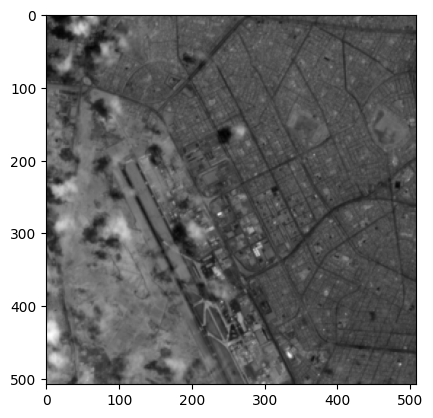

The image resolution is  (124, 124)
The number of colour channels are  52


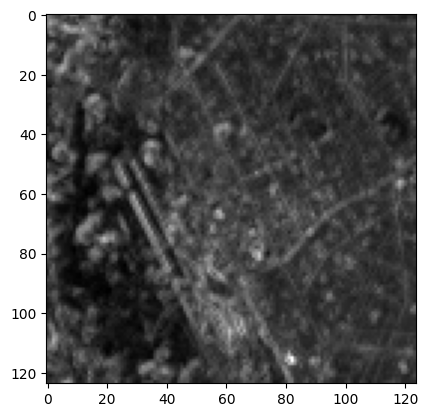

The image resolution is  (60, 60)
The number of colour channels are  104


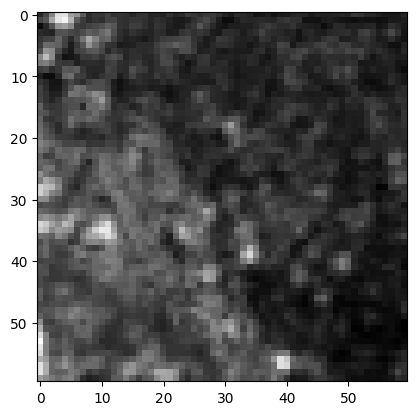

The image resolution is  (28, 28)
The number of colour channels are  208


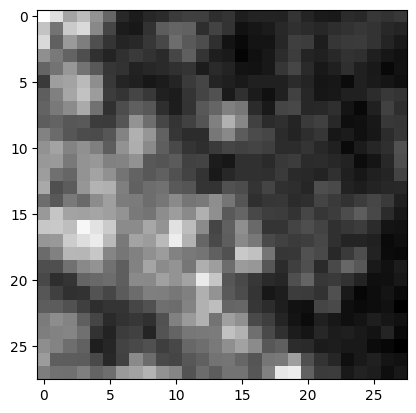

In [78]:
# show the image for debugging

import matplotlib.pyplot
#plt.imshow(B.numpy)

def mash_colour_channel(img):
  # img must be a Tensor array - format is [colour, x, y] or [z, x, y]

  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  print("The image resolution is ", img_no_colour.shape)
  print("The number of colour channels are ", z_size)
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

#combine the colour channels
mash_colour_channel(s2_l1c_data_tensor)
mash_colour_channel(B_pooled)
mash_colour_channel(C_pooled)
mash_colour_channel(D_pooled)

size_difference = 4
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 56, 56]) 
Output Size:		 torch.Size([104, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_trial
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 56, 56]) 
Output Size:		 torch.Size([104, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
The image resolution is  (56, 56)
The number of colour channels are  208


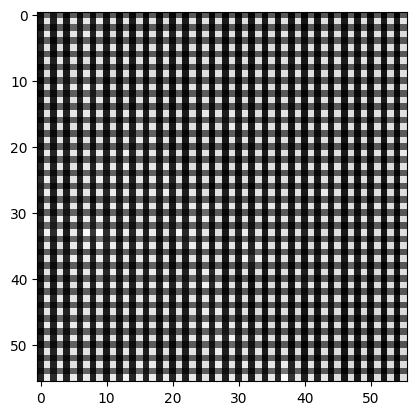

size_difference = 12
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([52, 112, 112]) 
Output Size:		 torch.Size([52, 112, 112]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_trial
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([52, 112, 112]) 
Output Size:		 torch.Size([52, 112, 112]) 
Output Device:		 cpu 
---------------------------------------------------
The image resolution is  (112, 112)
The number of colour channels are  104


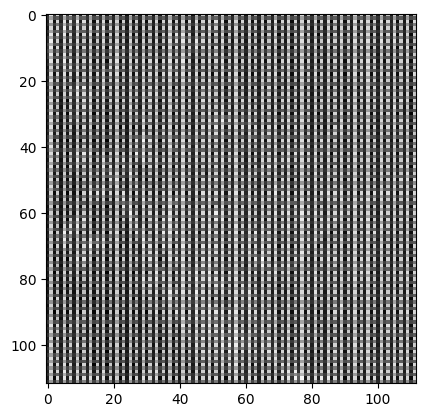

size_difference = 28
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([26, 224, 224]) 
Output Size:		 torch.Size([26, 224, 224]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_trial
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([26, 224, 224]) 
Output Size:		 torch.Size([26, 224, 224]) 
Output Device:		 cpu 
---------------------------------------------------
The image resolution is  (224, 224)
The number of colour channels are  52


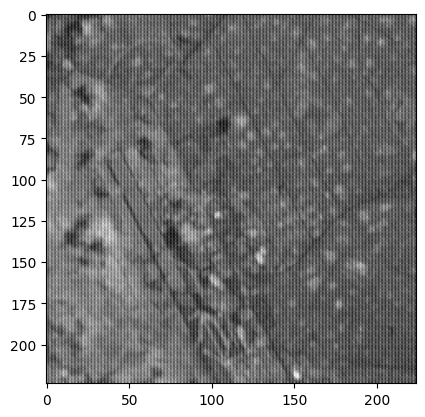

size_difference = 60
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([13, 448, 448]) 
Output Size:		 torch.Size([13, 448, 448]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_trial
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([13, 448, 448]) 
Output Size:		 torch.Size([13, 448, 448]) 
Output Device:		 cpu 
---------------------------------------------------
The image resolution is  (448, 448)
The number of colour channels are  26


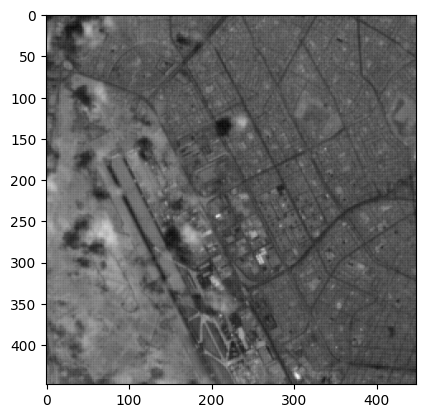

In [110]:
# decoder layer - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  #
  def __init__ (self, channels_in):
    super().__init__()

    # Deconvolution - an inverse of the convolution function - (not quite a deconvolution as inverse is not exact)
    # Used to counteract the impacts of pooling
    # deconvolute the image with a 2x2 kernal
    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_in,
        out_channels = int(channels_in / 2),
        kernel_size = [2, 2],
        stride = 2,
        dtype = torch.float32
    )

  def forward(self, img):
    output = self.deconv1(img)
    return output

# Setup
decoder_layer_1 = decoder_layer(channels_in = 208).to(device)
# concatenate prior to merger layer
C_deconv = decoder_layer_1(D_pooled)

decoder_layer_2 = decoder_layer(channels_in = 104).to(device)
# concatenate prior to merger layer
B_deconv = decoder_layer_2(C_pooled)

decoder_layer_3 = decoder_layer(channels_in = 52).to(device)
# concatenate prior to merger layer
A_deconv = decoder_layer_3(B_pooled)

decoder_layer_4 = decoder_layer(channels_in = 26).to(device)
# concatenate prior to merger layer
Z_deconv = decoder_layer_4(A_pooled)

# mash_colour_channel(C_deconv)
# mash_colour_channel(B_deconv)
# mash_colour_channel(A_deconv)
# mash_colour_channel(Z_deconv)

# propagated values
B_deconv1 = decoder_layer_2(C_deconv)
A_deconv1 = decoder_layer_3(B_deconv1)
Z_deconv1 = decoder_layer_4(A_deconv1)

def padding_insertion(img_deconv, img_pooled):
  # finds the difference in size between the deconvolution image and the pooled image
  # Also concatenates the padded deconvolution image with the pooled image
  size_difference =  img_pooled.shape[1] - img_deconv.shape[1]
  size_deconv_max = img_deconv.shape[1]
  print(f"{size_difference = }")
  if size_difference % 2 == 0:
    print("The image dimensions are EVEN. Thus padding is applied.")
    """
    # # Output image always has smaller diamensions than the input - hence no additional padding
    # # The input image must then be cropped to the requirements of the output
    # pad_offset = int(size_difference / 2)
    # padded_img = torch.nn.functional.pad(img_deconv, pad = (pad_offset, pad_offset, pad_offset, pad_offset))
    # # DEBUG SIZE DETAILS
    # # tensor_info(img_deconv, "original image (img_deconv)")
    # # tensor_info(padded_img, "padded image")
    # img_concat = torch.cat(tensors = (img_pooled, padded_img), dim = 0)
    # # mash_colour_channel(img_concat)
    # # mash_colour_channel(padded_img)
    # """

    # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
    img_trial = img_pooled[:, int(size_difference / 2) : size_deconv_max + int(size_difference / 2), int(size_difference / 2) : size_deconv_max + int(size_difference / 2)]
    tensor_info(img_deconv, "img_deconv")
    tensor_info(img_trial, "img_trial")

    img_concat = torch.cat(tensors = (img_deconv, img_trial), dim = 0)
    mash_colour_channel(img_concat)


    # Placeholder for now - return the padded result - may be convolute also
    #return padded_img

  else:
    print("The image dimensions are ODD. Thus padding can NOT be applied.", \
      "Please crop the image for a EVEN dimension.")
    return None

padding_insertion(
  img_deconv=C_deconv,
  img_pooled=C_pooled
)
test = padding_insertion(
  img_deconv=B_deconv1,
  img_pooled=B_pooled
)
test = padding_insertion(
  img_deconv=A_deconv1,
  img_pooled=A_pooled
)
test = padding_insertion(
  img_deconv=Z_deconv1,
  img_pooled=s2_l1c_data_tensor
)


In [49]:
#sandpit test for concatenation

C_deconv

# Experimentation and how many channels to add
tensor_info(D_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
tensor_info(C_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
tensor_info(C_pooled, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value

# print("\n")
# tensor_info(C_pooled, "STARTED VALUE - encoder_layer_3 - C1")       # started value
# tensor_info(B_deconv, "CURRENT VALUE - decoder_layer_2 - B_deconv") # current value
# tensor_info(B_pooled, "DESIRED VALUE - encoder_layer_2 - B1")       # desired value
# print("\n")
# # Later cases - use to prove relationship
# tensor_info(B_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
# tensor_info(A_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
# tensor_info(A_pooled, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value
# print("\n")
# tensor_info(A_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
# tensor_info(Z_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
# tensor_info(s2_l1c_data_tensor, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value
# print("\n PROPAGATED VALUES")
# tensor_info(C_deconv, "C_deconv")       # not-propagated value
# tensor_info(B_deconv1, "B_deconv1 propagated")       # propagated value
# tensor_info(A_deconv1, "A_deconv1 propagated")       # propagated value
# tensor_info(Z_deconv1, "Z_deconv1 propagated")       # propagated value


Tensor:			 STARTED VALUE - encoder_layer_4 - D1
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([208, 28, 28]) 
Output Size:		 torch.Size([208, 28, 28]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 CURRENT VALUE - decoder_layer_1 - C_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 56, 56]) 
Output Size:		 torch.Size([104, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 DESIRED VALUE - encoder_layer_3 - C1
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 60, 60]) 
Output Size:		 torch.Size([104, 60, 60]) 
Output Device:		 cpu 
---------------------------------------------------
